In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
pip install shap

In [3]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf   
import tensorflow.compat.v1.keras.backend as K
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle

import shap
import json

print("SHAP version is:", shap.__version__)
print("Tensorflow version is:", tf.__version__)

SHAP version is: 0.40.0
Tensorflow version is: 2.7.0


In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(tf.test.gpu_device_name())

/device:GPU:0


In [5]:
seed = 123
random.seed(seed) # Python
np.random.seed(seed) # numpy
tf.random.set_seed(seed) 
os.environ['PYTHONHASHSEED'] = str(seed)

In [6]:
base_dir = '/content/gdrive/MyDrive/research/images'
train_dir = os.path.join(base_dir, 'train')  
test_dir = os.path.join(base_dir, 'test')

In [7]:
class_name = os.listdir(train_dir)
class_name_test = os.listdir(test_dir)
print(class_name)
print(class_name_test)

['american_makeup', 'korean_makeup']
['american_makeup', 'korean_makeup']


In [8]:
integer_encoded = LabelEncoder().fit_transform(class_name)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = OneHotEncoder(sparse=False).fit_transform(integer_encoded)
print(onehot_encoded)

integer_encoded_test = LabelEncoder().fit_transform(class_name_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoded_test = OneHotEncoder(sparse=False).fit_transform(integer_encoded_test)

print(onehot_encoded_test)

[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]


In [9]:
train_image = []
train_label = []
test_image = []
test_label = []

In [10]:
for i in range(len(class_name)):
    path = os.path.join(train_dir, class_name[i])
    img_list = os.listdir(path)
    for j in img_list:
        img = os.path.join(path, j)
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_CUBIC)    
        img = img.reshape((100, 100, 3)) 
        train_image.append(img)
        train_label.append(onehot_encoded[i])  

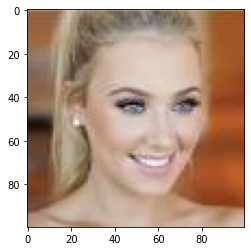

In [11]:
plt.imshow(train_image[0])

In [12]:
for i in range(len(class_name_test)):
    path = os.path.join(test_dir, class_name_test[i])
    img_list = os.listdir(path)
    for j in img_list:
        img = os.path.join(path, j)
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_CUBIC)    
        img = img.reshape((100, 100, 3)) 
        test_image.append(img)
        test_label.append(onehot_encoded_test[i])  

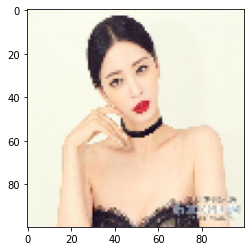

In [13]:
plt.imshow(test_image[11])

In [14]:
print(len((train_image)), len(train_label)) 
print(len(test_image), len(test_label))

train_image = np.array(train_image)
train_label = np.array(train_label)
print(train_image.shape)
print(train_label.shape)

test_image = np.array(test_image)
test_label = np.array(test_label)
print(test_image.shape)
print(test_label.shape)

283 283
20 20
(283, 100, 100, 3)
(283, 2)
(20, 100, 100, 3)
(20, 2)


In [15]:
X_train = shuffle(train_image.reshape(283, 100, 100, 3).astype("float32") / 255, random_state = seed)
X_test = shuffle(test_image.reshape(20, 100, 100, 3).astype("float32") / 255, random_state = seed)

train_label = shuffle(train_label, random_state = seed)
test_label = shuffle(test_label, random_state = seed)

In [16]:
def CNN():
    input_layer = keras.Input(shape=(100,100,3))
    x = keras.layers.Conv2D(150, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=seed))(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(150, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=seed))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(150, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=seed))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(150, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=seed))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation='relu', kernel_initializer = keras.initializers.HeUniform(seed=seed))(x)
    x = keras.layers.Dropout(0.5)(x)
    output_layer = keras.layers.Dense(2, activation='sigmoid')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer, name = 'CNN')
    model.compile(loss='binary_crossentropy', optimizer= keras.optimizers.SGD(learning_rate=0.001),  metrics=['acc', 'AUC'])
    return model 

In [17]:
model = CNN()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 150)     4200      
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 150)    600       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 150)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 150)       202650    
                                                         

In [18]:
model.fit(X_train, train_label,  batch_size=16, epochs=250, validation_data=(X_test, test_label))

Train on 283 samples, validate on 20 samples
Epoch 1/250
283/283 [==============================] - ETA: 0s - loss: 1.0938 - acc: 0.5265 - AUC: 0.5362

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


283/283 [==============================] - 4s 16ms/sample - loss: 1.0938 - acc: 0.5265 - AUC: 0.5362 - val_loss: 0.8723 - val_acc: 0.5000 - val_AUC: 0.6100
Epoch 2/250
283/283 [==============================] - 1s 5ms/sample - loss: 0.8437 - acc: 0.6007 - AUC: 0.6628 - val_loss: 0.7742 - val_acc: 0.5000 - val_AUC: 0.6125
Epoch 3/250
283/283 [==============================] - 1s 5ms/sample - loss: 0.7256 - acc: 0.6731 - AUC: 0.7287 - val_loss: 0.7639 - val_acc: 0.5000 - val_AUC: 0.6025
Epoch 4/250
283/283 [==============================] - 1s 5ms/sample - loss: 0.6351 - acc: 0.7226 - AUC: 0.7799 - val_loss: 0.7293 - val_acc: 0.5250 - val_AUC: 0.5950
Epoch 5/250
283/283 [==============================] - 1s 5ms/sample - loss: 0.5366 - acc: 0.7138 - AUC: 0.8220 - val_loss: 0.7187 - val_acc: 0.5500 - val_AUC: 0.5838
Epoch 6/250
283/283 [==============================] - 1s 5ms/sample - loss: 0.4455 - acc: 0.7668 - AUC: 0.8704 - val_loss: 0.7024 - val_acc: 0.5500 - val_AUC: 0.6087
Epoch 7/2

Prediction :  1
Ground Truth :  1


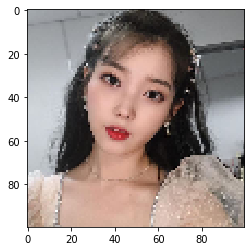

In [36]:
idx = 6
input_val = X_test[idx:idx+1]
output_val = model.predict(input_val)
real = test_label[idx:idx+1]
print("Prediction : ", np.argmax(output_val))
print("Ground Truth : ", np.argmax(real))

plt.imshow(
  input_val.reshape(100, 100, 3),
  interpolation='nearest')
plt.show()

In [20]:
results = model.evaluate(X_test, test_label)
print('test loss, test acc, test auc:', results)

test loss, test acc, test auc: [0.4245772361755371, 0.825, 0.92]


In [21]:
prediction = []
label = []
for idx in range(20): 
  prediction.append(np.argmax(model.predict(X_test[idx:idx+1])))
  label.append(np.argmax(test_label[idx:idx+1]))

df = pd.DataFrame({'Predcition': prediction, 'Label': label})

In [22]:
df

,Predcition,Label
0,1,1
1,0,0
2,0,0
3,1,1
4,1,0
5,1,0
6,1,1
7,1,1
8,0,0
9,1,1


In [23]:
background = X_test
e = shap.DeepExplainer(model, background)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [24]:
# reduced batch(16) and input dimension(100) and gpu
shap_values = e.shap_values(X_test[0:20])

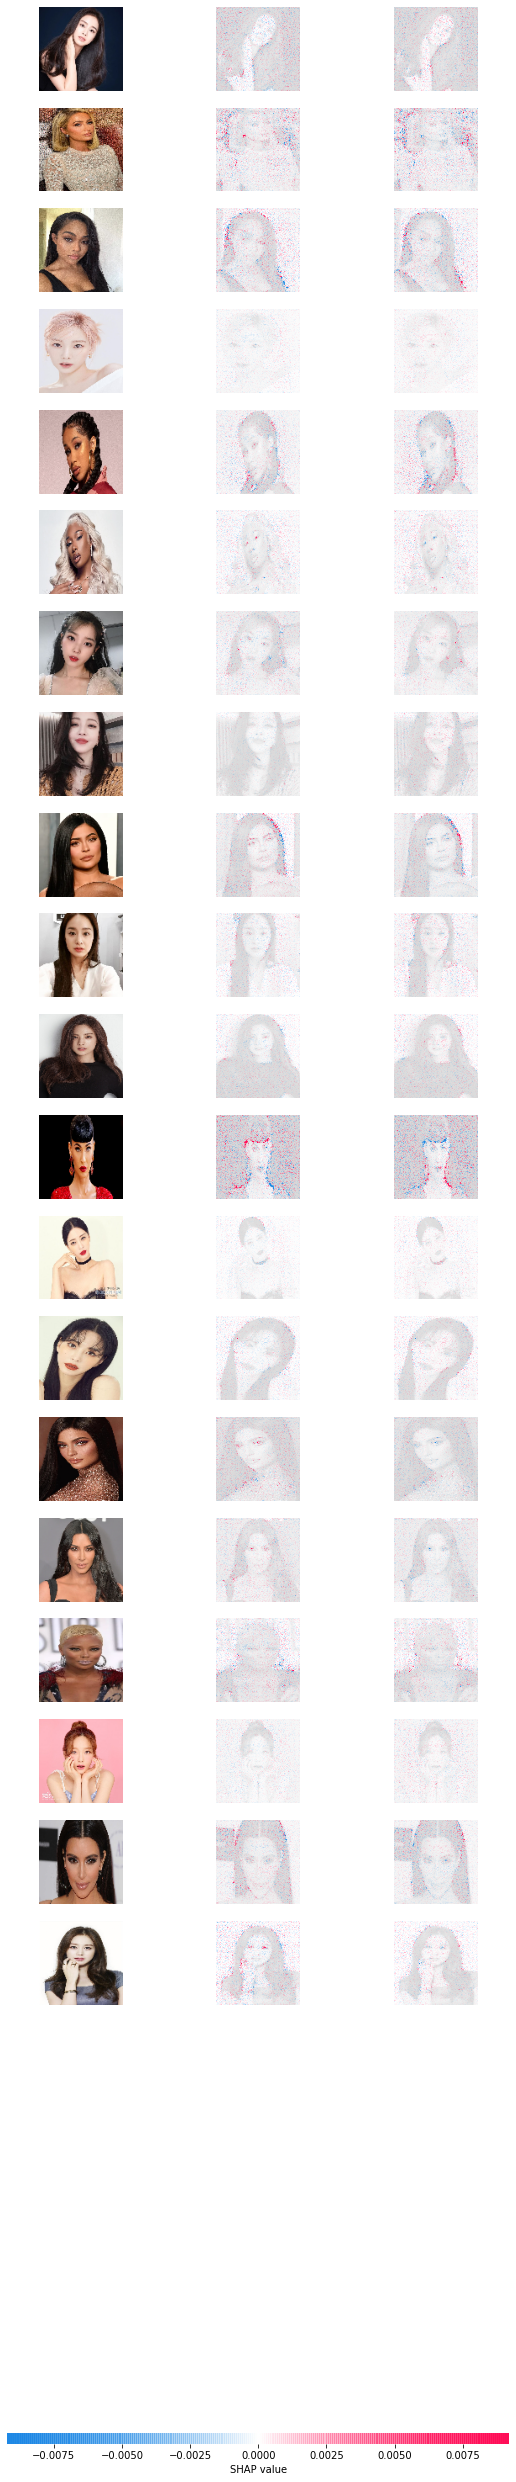

In [25]:
shap.image_plot(shap_values, X_test[0:20])

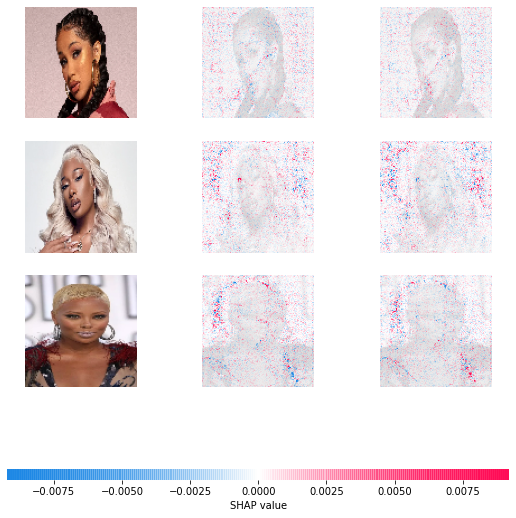

In [26]:
shap.image_plot(shap_values, X_test[[4,5,16]])